# Treebeard and the Fungus Amongus
The data we explore today (whatever day it is for you) is the [mushroom data](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/) found at the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).  

The type of exploration, you ask?  



![Treebeard](./assets/Treebeard.jpg)

Asking sentient trees what they know about poisonous mushrooms, of course. 

In the process, maybe we will learn a thing or two about these 
[arboreal decision makers](http://scikit-learn.org/stable/modules/tree.html#tree).

In [22]:
# Get Mushroom Data
# -- uncomment if necessary
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

# Extract lines w/ feature names
#  -- you might use python to do this; I just use whatever quickly comes to mind
# -- uncomment if necessary
#!cat agaricus-lepiota.names | grep "^[[:space:]]\{4,5\}[0-9]\{1,2\}.*:" > feature_names.txt

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import feature_selection as filt
%matplotlib inline

Read in the data with [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html),
making sure to specify the names. (Simple inspection of the file shows that the target variable is in the first column, followed by the features.)

In [3]:
# Extract features names
with open('feature_names.txt') as f:
    features = [line.split()[1][0:-1] for line in f]
    
# Get Data
data = pd.read_csv('agaricus-lepiota.data', names=['deadly']+features)
y = pd.DataFrame([1 if target=='p' else 0 for target in data['deadly']], columns=['deadly'])
x = data.drop('deadly', axis=1)

# Train, Validate, Test
x_trn, x_vt, y_trn, y_vt = train_test_split(x, y, train_size=0.70)
x_val, x_tst, y_val, y_tst = train_test_split(x_vt, y_vt, test_size=0.50)

# Some/Most techniques require the categorical vars to be one-hot encoded
x_trn_code = pd.get_dummies(x_trn)
x_val_code = pd.get_dummies(x_val)
x_tst_code = pd.get_dummies(x_tst)

# Make sure the various dummy vars are represented in each subset
all_ftrs = pd.get_dummies(x).columns
for ftr in all_ftrs.difference(x_trn_code.columns): x_trn_code[ftr]=0
for ftr in all_ftrs.difference(x_val_code.columns): x_val_code[ftr]=0
for ftr in all_ftrs.difference(x_tst_code.columns): x_tst_code[ftr]=0

## Are these classes balanced or imbalanced?
Turns out they're pretty dang balanced, which means we don't have to think too much.
But beware: rarely are classes balanced in the "real" world.  (No, mushrooms are not real!)

In [4]:
y_trn.sum() / y_trn.count()

deadly    0.484699
dtype: float64

## A Tree
Interestingly, from a theoretical perspective, decision trees can handle categorical
variables just fine without one-hot encoding them.  However, [from an implementation perspective,
this is not necessarily true](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/). Turns out, one-hot encoding can degrade the performance (beware the curse of dimensionality!).  But [scikit-learn don't care](https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest)!  In scikit-learn, you **have** to one-hot encode the categorical features.  

Note that this is a bummer since one of the desirable traits of decision trees is the fact that they require almost no preprocessing (no need for logs or Box-Cox, normalization, etc).  So, one thing to add to this project is to also do a decision tree (and random forest) in R to see how the results differ.

In sklearn, we have various options for a [decision tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier):
* criterion: 
    - Default: 'gini' (Gini impurity)
    - 'entropy' (information gain)
* splitter: 
    - Default: 'best'
    - 'random'
* max_features
    - Default: None (max_features = n_features)
    - int (consider int features at each split), e.g., 3
    - float (percentage of total features considered at each split), e.g., 0.5
    - 'auto' (max_features = sqrt(n_features))
    - 'sqrt' (same as 'auto')
    - 'log2' (can you guess?)
* max_depth
    - Default: None (go deep!)
    - int: do not go further than int splits
    - if None, splits continue until all leaves are pure or min_samples_split is reached
* min_samples_split
    - Default: 2 (i.e., split until leaf is pure or some other constraint is met)
    - int (split if n_data_points_in_node >= int, barring no other constraint prevents such)
    - float (split if n_data_points_in_node >= ceil(float\*n_data_points), barring no other constraint)
* min_samples_leaf
    - 
* min_weight_fraction_leaf
* max_leaf_nodes
* class_weight
* random_state
* min_impurity_split

Whoa, all these options... It's like ice cream or beer: too many choices, damn it!

No worries... Let's just play around with them.  Maybe we will learn something!  
(Disclaimer: Or maybe not.)

In [5]:
gin_tree = DecisionTreeClassifier(random_state=0, criterion='gini')
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
gin_tree.fit(x_trn_code, y_trn)
ent_tree.fit(x_trn_code, y_trn)
print('Gini:',    metrics.f1_score(y_val, gin_tree.predict(x_val_code)))
print('Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code)))

Gini: 0.433333333333
Entropy: 0.623222748815


You can do a "bootstrapping" of sorts by changing the random_state and finding the median. (Obviously this is ok for this small data set...but becomes less ok as N -> BIG!)

In [6]:
# Probably a more efficient way of doing this than forLoop, but uhhh... Look over there! -->
gf1=list(); ef1=list()
for i in range(1000):
    gin_tree = DecisionTreeClassifier(random_state=i, criterion='gini')
    ent_tree = DecisionTreeClassifier(random_state=i, criterion='entropy')
    gin_tree.fit(x_trn_code, y_trn)
    ent_tree.fit(x_trn_code, y_trn)
    gf1.append(metrics.f1_score(y_val, gin_tree.predict(x_val_code)))
    ef1.append(metrics.f1_score(y_val, ent_tree.predict(x_val_code)))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114f8ca58>]], dtype=object)

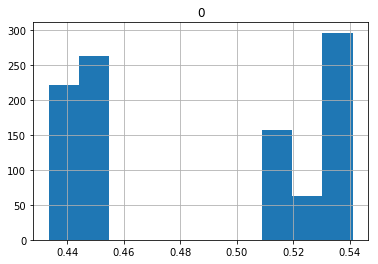

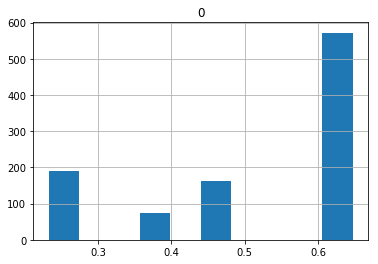

In [7]:
pd.DataFrame(gf1).hist()
pd.DataFrame(ef1).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1110773c8>]], dtype=object)

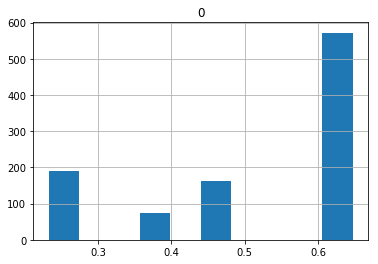

In [8]:
pd.DataFrame(ef1).hist()

# Will Feature Selection Help?
Oftentimes feature selection is used with at least two goals in mind:
- discard features that have almost no "information value" with regard to the target
- remove collinearity among the features

Both are meant to address various issues, such as the curse of dimensionality and 
overfitting.  Removing collinearity in some models is essential, while in other
it is just helpful.  Removing seemingly useless variables helps hedge against 
fitting to noise.  

Anyway, the point is feature selection (here synonymous with dimensionality reduction)
is often an important step for improving model performance in various ways. How it might
help with decision trees is something we will address.

More generally, one might what wonder which issue to address first.  My answer is 
to first reduce your feature space by discarding variables that seem to have little
to say about the target.  For example, say you have N features and you 
want to (a) order your features by
how well they individually correlate with the target, and (b) identify groups of
highly correlated features to select single representatives from.  

A: If you choose step (a) then (b), you will (1) compute N correlations with target, keeping only 
M <= N; and (2) compute (M-1)+(M-2)+...+1 correlations.  

B: If you choose step (b) then (a), you will (1) compute (N-1)+(N-2)+...+1 correlations,
and choose to keep P <= N features; and (2) compute P correlations with target.

In scenario A, you will always compute at least N correlations and, at most,
N+(N-1)+...+1 correlations (discard no features). 

In scenario B, you will always compute at least (N-1)+(N-2)+...+1 correlations. 


## Pairwise Correlation Filters
This is sometimes referred to as univariate feature selection. I like to think
about it as filtering a list of features, allowing only those with certain desirable
qualities to pass.

In [9]:
num_ftrs = 8
chi2_filt     = filt.SelectKBest(filt.chi2, k=num_ftrs).fit(x_trn_code, y_trn.squeeze())
chi2_ftrs = x_trn_code.columns[chi2_filt.get_support()]

fval_filt     = filt.SelectKBest(filt.f_classif, k=num_ftrs).fit(x_trn_code, y_trn.squeeze())
fval_ftrs = x_trn_code.columns[fval_filt.get_support()]

info_filt     = filt.SelectKBest(filt.mutual_info_classif, k=num_ftrs).fit(x_trn_code, y_trn.squeeze())
info_ftrs = x_trn_code.columns[info_filt.get_support()]

best_ftrs = fval_ftrs.intersection(chi2_ftrs).intersection(info_ftrs)

/Users/kurban/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [82] are constant.
  UserWarning)
/Users/kurban/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
print('The important features to consider when deciding whether or not to eat that mushroom:')
_ = [print("\t",ftr) for ftr in best_ftrs.tolist()]

The important features to consider when deciding whether or not to eat that mushroom:
	 odor_f
	 odor_n
	 gill-size_n
	 gill-color_b
	 stalk-surface-above-ring_k
	 stalk-surface-below-ring_k


In [11]:
gin_tree = DecisionTreeClassifier(random_state=0, criterion='gini')
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
gin_tree.fit(x_trn_code[best_ftrs], y_trn)
ent_tree.fit(x_trn_code[best_ftrs], y_trn)
print('Gini:',    metrics.f1_score(y_val, gin_tree.predict(x_val_code[best_ftrs])))
print('Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code[best_ftrs])))


Gini: 0.981132075472
Entropy: 0.981132075472


Wow. Feature selection helped a lot.  So much so that it doesn't even matter if Treebeard makes decisions 
using the Gini or Entropy criterion!

I found that choosing the 12 best features for each filter had an intersection of 8, and identical
F1 scores for the Gini and Entropy criteria (just over 0.979).  

Interestingly, I found that choosing the 8 best features had an intersection of 6 features, and the 
same F1 scores.  

However, if one chooses to look for the 7 best features, the 3 filters have an intersection of only 5 features and 
the F1 scores drop to just above 0.92 (though still identical, believe it or not).

### If we couldn't take the intersection of multiple feature filters, which would have done best?

In [12]:
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(x_trn_code, y_trn)
print('Entropy (No Filter):', metrics.f1_score(y_val, ent_tree.predict(x_val_code)))

Entropy (No Filter): 0.623222748815


In [13]:
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(x_trn_code[chi2_ftrs], y_trn)
print('Chi2 Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code[chi2_ftrs])))
print('\nFeatures not in the Best Set')
_ = [print("\t",ftr) for ftr in chi2_ftrs.difference(best_ftrs).tolist()]

Chi2 Entropy: 0.981132075472

Features not in the Best Set
	 ring-type_l
	 spore-print-color_h


In [14]:
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(x_trn_code[fval_ftrs], y_trn)
print('F-Value Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code[fval_ftrs])))
print('\nFeatures not in the Best Set')
_ = [print("\t",ftr) for ftr in fval_ftrs.difference(best_ftrs).tolist()]

F-Value Entropy: 0.981132075472

Features not in the Best Set
	 gill-size_b
	 ring-type_p


In [15]:
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(x_trn_code[info_ftrs], y_trn)
print('Info Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code[info_ftrs])))
print('\nFeatures not in the Best Set')
_ = [print("\t",ftr) for ftr in info_ftrs.difference(best_ftrs).tolist()]

Info Entropy: 0.981132075472

Features not in the Best Set
	 gill-size_b
	 ring-type_p


## Multicollinearity: Seek and Destroy?

1. Create feature corr matrix
2. Mask: Surface only those (row,col) pairs w/ 
    - corr > threshold
    - corrs != 1.0000 (the (i,i) pairs along the diagonal)
3. Convert matrix into (row_name, col_name, corr_value) representation
    - this can be done using the [stack](https://stackoverflow.com/questions/26854091/getting-index-column-pairs-for-true-elements-of-a-boolean-dataframe-in-pandas) method, which turns the DataFrame into a multi-index Series, and then [resetting the Series index](https://stackoverflow.com/questions/20110170/turn-pandas-multi-index-into-column) 



In [34]:
def high_corrs(x_code, threshold=0.5, drop=None):
    #x_corr = x_trn_code[best_ftrs.drop(['odor_f','gill-size_n', 'stalk-surface-above-ring_k'])].corr().abs()
    if drop is None:
        x_corr = x_code[best_ftrs].corr().abs()
        high_corrs = x_corr[(x_corr >= threshold) & (x_corr != 1.000000)].\
            stack().\
            reset_index().\
            rename(columns={'level_0': 'row', 'level_1': 'col', 0: 'val'}).\
            drop_duplicates('val')
    else:
        x_corr = x_code[best_ftrs.drop(drop)].corr().abs()
        high_corrs = x_corr[(x_corr >= threshold) & (x_corr != 1.000000)].\
            stack().\
            reset_index().\
            rename(columns={'level_0': 'row', 'level_1': 'col', 0: 'val'}).\
            drop_duplicates('val')
    return high_corrs

In [35]:
high_corrs(x_trn_code)

,row,col,val
0,odor_f,odor_n,0.522712
1,odor_f,stalk-surface-above-ring_k,0.580559
2,odor_f,stalk-surface-below-ring_k,0.600382
4,gill-size_n,gill-color_b,0.779978
7,stalk-surface-above-ring_k,stalk-surface-below-ring_k,0.673061


In [36]:
# Looks like we can drop odor_f, gill-size_n, and stalk-surface-above-ring_k
high_corrs(x_trn_code, drop=['odor_f','gill-size_n', 'stalk-surface-above-ring_k'])

,row,col,val


In [19]:
bf = best_ftrs.drop(['odor_f','gill-size_n', 'stalk-surface-above-ring_k'])
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(x_trn_code[bf], y_trn)
print('Info Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code[bf])))

Info Entropy: 0.86931268151


### What happened?
You have to ask: why do I care about collinearity?  The reason would be because you deeply care about understanding the effect of each feature independently of all other features.  But if you care only about prediction performance, 
there is no need to care too much about collinearity.  Sure, some variables share a lot of the same info about the target, but they also may contain small bits of independent info as well.  So if you don't need to explain every detail about your model, keep 'em all!

### To hell with understanding: Let's Predict the Future!

In [23]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(x_trn_code[best_ftrs], y_trn)
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(pca.transform(x_trn_code[best_ftrs]), y_trn)
print('Entropy F1:', \
      metrics.f1_score(y_val, ent_tree.predict(pca.transform(x_val_code[best_ftrs]))))

Entropy F1: 0.981132075472


You should basically be thinking, "Oh my God! That can't be real."

We've literally reduced the 100+ dimensions of the input feature space to a single dimension, and it performs
just as well as our 6 best features.  That is amazing.

Would PCA have worked out so well if we had done this from the beginning?  

Absolutely not.  PCA is an unsupervised dimensionality reduction technique that equates feature variance 
with feature importance.  This consideration is independent of any information regarding the target.  
PCA worked so well this time solely because we first reduced the feature space to the 6 most essential
features.  In other words, we threw out any noise and irrelevant information that would have 
rendered PCA useless.  (Rotten icing on the moldy cake: Even if PCA did not suffer these issues, it would have been more computationally demanding to do it first. )



In [24]:
# Show the kids how blindly applying PCA would have worked out
pca = PCA(1).fit(x_trn_code, y_trn)
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
ent_tree.fit(pca.transform(x_trn_code), y_trn)
print('Entropy F1:', \
      metrics.f1_score(y_val, ent_tree.predict(pca.transform(x_val_code))))

Entropy F1: 0.0939794419971
